In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import datetime as dt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
import yfinance as yf
import pandas as pd

# === Date ranges ===
train_start = "2005-01-01"
train_end   = "2025-01-01"
test_start  = "2025-01-01"
test_end    = pd.Timestamp.today()

# === Stock Data ===
symbol = "RELIANCE.NS"
df = yf.download(symbol, start=train_start, end=pd.Timestamp.today(), auto_adjust=True)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)
df = df[['Open','High','Low','Close','Volume']]

# === Stock Info ===
ticker = yf.Ticker(symbol)
info = ticker.info
print("Company:", info.get("longName"))
print("Sector:", info.get("sector"))
print("Industry:", info.get("industry"))

# === Sector mapping (updated with working yfinance tickers) ===
sector_map = {
    "Financial Services": "^NSEBANK",
    "Banks": "^NSEBANK",
    "Technology": "^CNXIT",
    "Energy": "^CNXENERGY",
    "Consumer Defensive": "^CNXFMCG",
    "Healthcare": "^CNXPHARMA",
    "Pharmaceuticals": "^CNXPHARMA",
    "Consumer Cyclical": "^CNXAUTO",
    "Basic Materials": "^CNXMETAL",
    "Real Estate": "^CNXREALTY"
}

# Fallback: Nifty 50
sector_symbol = sector_map.get(info.get("sector"), "^NSEI")
print("Using sector index:", sector_symbol)

# === Sector Data ===
sector_df = yf.download(sector_symbol, start=train_start, end=pd.Timestamp.today(), auto_adjust=True)
if isinstance(sector_df.columns, pd.MultiIndex):
    sector_df.columns = sector_df.columns.get_level_values(0)
sector_df = sector_df[['Close']].rename(columns={'Close':'Sector_Close'})

# === Merge stock + sector ===
df = df.join(sector_df, how="inner")

# === Indicators for stock ===
df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['EMA50'] = df['Close'].ewm(span=50, adjust=False).mean()

delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

ema12 = df['Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# === Indicators for sector ===
df['Sector_EMA20'] = df['Sector_Close'].ewm(span=20, adjust=False).mean()
df['Sector_EMA50'] = df['Sector_Close'].ewm(span=50, adjust=False).mean()

sector_delta = df['Sector_Close'].diff()
sector_gain = (sector_delta.where(sector_delta > 0, 0)).rolling(14).mean()
sector_loss = (-sector_delta.where(sector_delta < 0, 0)).rolling(14).mean()
sector_rs = sector_gain / sector_loss
df['Sector_RSI'] = 100 - (100 / (1 + sector_rs))

sector_ema12 = df['Sector_Close'].ewm(span=12, adjust=False).mean()
sector_ema26 = df['Sector_Close'].ewm(span=26, adjust=False).mean()
df['Sector_MACD'] = sector_ema12 - sector_ema26
df['Sector_MACD_Signal'] = df['Sector_MACD'].ewm(span=9, adjust=False).mean()

# === Clean ===
df.dropna(inplace=True)
print(df.shape)
df.tail()


[*********************100%***********************]  1 of 1 completed


Company: Bharti Airtel Limited
Sector: Communication Services
Industry: Telecom Services
Using sector index: ^NSEI


[*********************100%***********************]  1 of 1 completed

(4383, 16)


Price,Open,High,Low,Close,Volume,Sector_Close,EMA20,EMA50,RSI,MACD,MACD_Signal,Sector_EMA20,Sector_EMA50,Sector_RSI,Sector_MACD,Sector_MACD_Signal
Date,,,,,,,,,,,,,,,,
2025-08-12,1857.400024,1865.000000,1847.099976,1850.300049,4645011,24487.400391,1905.705917,1899.073307,33.092224,-13.550104,-5.302323,24765.870472,24828.105301,30.549695,-164.293495,-128.543049
2025-08-13,1853.000000,1872.500000,1851.800049,1867.400024,6697206,24619.349609,1902.057737,1897.831218,37.985314,-14.764866,-7.194832,24751.916104,24819.918803,38.079869,-154.856025,-133.805644
2025-08-14,1873.000000,1883.000000,1866.800049,1873.800049,3958631,24631.300781,1899.366528,1896.888819,38.967297,-15.037798,-8.763425,24740.428930,24812.522018,43.743956,-144.743886,-135.993293
2025-08-18,1892.500000,1912.599976,1870.300049,1892.300049,7146376,24876.949219,1898.693530,1896.708867,50.382556,-13.604480,-9.731636,24753.430862,24815.048575,55.654539,-115.575879,-131.909810
2025-08-19,1901.099976,1931.800049,1900.000000,1909.699951,5706265,24980.650391,1899.741761,1897.218321,48.285466,-10.938446,-9.972998,24775.070817,24821.542764,54.700814,-83.133891,-122.154626


In [24]:
features = ['Close','Open', 'High', 'Low', 'Volume', 'Sector_Close', 'EMA20',
       'EMA50', 'RSI', 'MACD', 'MACD_Signal', 'Sector_EMA20', 'Sector_EMA50',
       'Sector_RSI', 'Sector_MACD', 'Sector_MACD_Signal']
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])

lookback = 60
X, y = [], []
for i in range(lookback, len(scaled)):
    X.append(scaled[i-lookback:i])
    y.append(scaled[i,0])  # Close
X, y = np.array(X), np.array(y)

# Split into train/test
split_idx = int(0.9*len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("X_train:", X_train.shape, "X_test:", X_test.shape)

X_train: (3890, 60, 16) X_test: (433, 60, 16)


In [25]:
# import numpy as np
# import pandas as pd
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.preprocessing import MinMaxScaler
# import matplotlib.pyplot as plt

# # Features
# features = ['Close','Open', 'High', 'Low', 'Volume', 'Sector_Close',
#             'EMA20', 'EMA50', 'RSI', 'MACD', 'MACD_Signal',
#             'Sector_EMA20', 'Sector_EMA50', 'Sector_RSI',
#             'Sector_MACD', 'Sector_MACD_Signal']

# # Scale
# scaler = MinMaxScaler()
# scaled = scaler.fit_transform(df[features])

# # Prepare sequences
# lookback = 60
# X_rf, y_rf = [], []
# for i in range(lookback, len(scaled)):
#     X_rf.append(scaled[i-lookback:i])  # shape (lookback, features)
#     y_rf.append(scaled[i, 0])          # Close

# X_rf, y_rf = np.array(X_rf[:1000]), np.array(y_rf[:1000])
# print("X shape before flattening:", X_rf.shape)

# # Flatten time dimension for RandomForest
# n_samples, n_steps, n_features = X_rf.shape
# X_flat = X_rf.reshape(n_samples, n_steps * n_features)
# print("X shape after flattening:", X_flat.shape)

# # Train/test split
# split_idx = int(0.75*len(X_flat))
# X_train, X_test = X_flat[:split_idx], X_flat[split_idx:]
# y_train, y_test = y_rf[:split_idx], y_rf[split_idx:]

# # Train Random Forest
# rf = RandomForestRegressor(n_estimators=100, random_state=42)
# rf.fit(X_train, y_train)

# # Feature importances
# importances = rf.feature_importances_

# # Map importances back to feature names (average over lookback window)
# importances_per_feature = np.mean(importances.reshape(lookback, n_features), axis=0)

# # Plot
# plt.figure(figsize=(12,6))
# plt.bar(features, importances_per_feature)
# plt.xticks(rotation=45)
# plt.ylabel("Importance")
# plt.title("Random Forest Feature Importance for predicting Close")
# plt.show()


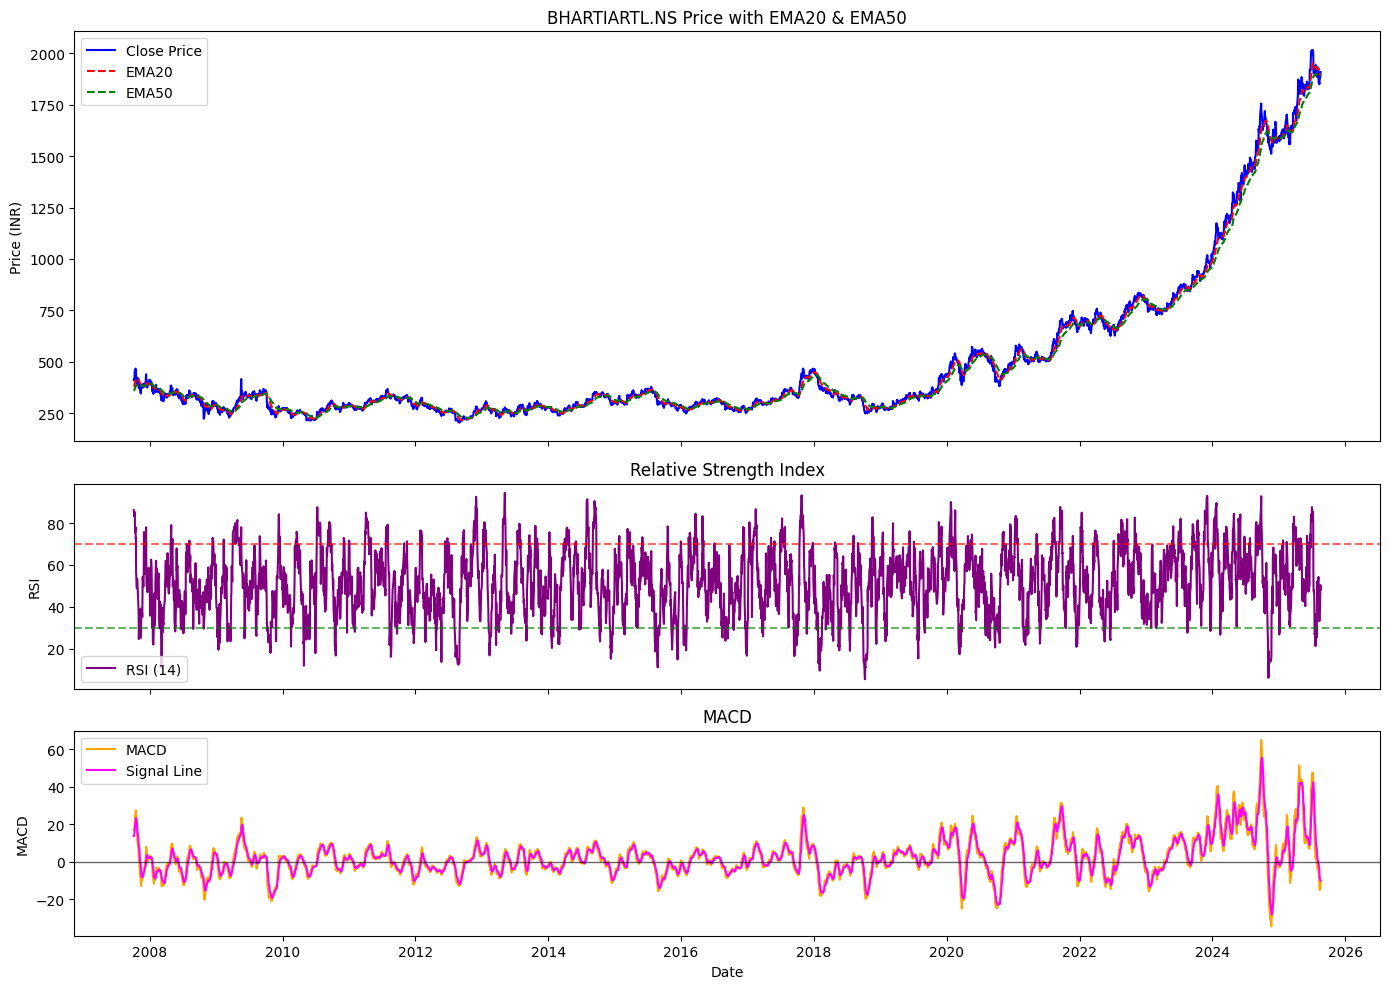

In [26]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14,10), sharex=True, gridspec_kw={'height_ratios':[2,1,1]})

# --- Price with EMA ---
ax1.plot(df.index, df['Close'], label='Close Price', color='blue')
ax1.plot(df.index, df['EMA20'], label='EMA20', color='red', linestyle='--')
ax1.plot(df.index, df['EMA50'], label='EMA50', color='green', linestyle='--')
ax1.set_title(f"{symbol} Price with EMA20 & EMA50")
ax1.set_ylabel("Price (INR)")
ax1.legend()

# --- RSI ---
ax2.plot(df.index, df['RSI'], label='RSI (14)', color='purple')
ax2.axhline(70, color='red', linestyle='--', alpha=0.6)   # Overbought
ax2.axhline(30, color='green', linestyle='--', alpha=0.6) # Oversold
ax2.set_ylabel("RSI")
ax2.set_title("Relative Strength Index")
ax2.legend()

# --- MACD ---
ax3.plot(df.index, df['MACD'], label='MACD', color='orange')
ax3.plot(df.index, df['MACD_Signal'], label='Signal Line', color='magenta')
ax3.axhline(0, color='black', linewidth=1, alpha=0.6)
ax3.set_ylabel("MACD")
ax3.set_title("MACD")
ax3.legend()

plt.xlabel("Date")
plt.tight_layout()
plt.show()


In [27]:
train_df = df.loc[train_start:train_end]
test_df  = df.loc[test_start:test_end]

print("Train size:", train_df.shape)
print("Test size:", test_df.shape)
df.shape

Train size: (4226, 16)
Test size: (158, 16)


(4383, 16)

In [28]:
from keras.layers import Input
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

lstm = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])), # Explicitly define input shape
    LSTM(256, return_sequences=True),
    Dropout(0.2),
    LSTM(128,return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')

history = lstm.fit(
    X_train, y_train,
    epochs=50, batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 44s 349ms/step - loss: 0.0178 - val_loss: 6.0609e-04 - learning_rate: 0.0010
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 40s 341ms/step - loss: 2.8899e-04 - val_loss: 4.4517e-04 - learning_rate: 0.0010
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 332ms/step - loss: 2.1660e-04 - val_loss: 1.2161e-04 - learning_rate: 0.0010
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 334ms/step - loss: 1.9324e-04 - val_loss: 1.9104e-04 - learning_rate: 0.0010
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 336ms/step - loss: 1.6423e-04 - val_loss: 3.0862e-04 - learning_rate: 0.0010
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 1.7344e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 333ms/step - loss: 1.7332e-04 - val_loss: 4.8493e-04 - learning_rate: 0.0010
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 334ms/step - loss: 1.4733e-04 - val_loss: 3.0428e-04 - learning_rate: 5.0000e-04
Epoch 8/50
110/

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.linear_model import LinearRegression
import numpy as np

# ===== Positional Encoding =====
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.pe[:, :x.size(1)]

# ===== Transformer Model =====
class TransformerModel(nn.Module):
    def __init__(self, feature_size: int, hidden_dim: int = 32, num_heads: int = 4,
                 num_layers: int = 2, dropout: float = 0.1):
        super().__init__()
        self.embedding = nn.Linear(feature_size, hidden_dim)
        self.pos_encoder = PositionalEncoding(hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(hidden_dim, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        return self.fc_out(x[:, -1, :])

# ===== Helper Functions =====
def inverse_transform(scaled_values: np.ndarray, scaler, features_len: int) -> np.ndarray:
    """Inverse transform a single target column using scaler."""
    return scaler.inverse_transform(
        np.concatenate([scaled_values, np.zeros((len(scaled_values), features_len-1))], axis=1)
    )[:,0]

def train_model(model: nn.Module, train_data: TensorDataset, val_data: TensorDataset,
                criterion, optimizer, epochs: int = 50, patience: int = 5, device=None):
    best_val_loss = float("inf")
    wait = 0
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * X_batch.size(0)

        avg_train_loss = total_loss / len(train_data)

        # Validation
        model.eval()
        with torch.no_grad():
            X_val, y_val = val_data.tensors
            X_val, y_val = X_val.to(device), y_val.to(device)
            val_pred = model(X_val)
            val_loss = criterion(val_pred, y_val).item()

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping 🚀")
                break

    model.load_state_dict(best_weights)
    return model


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== Prepare Data =====
# Convert numpy arrays to torch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # shape (N,1)
X_test_torch  = torch.tensor(X_test, dtype=torch.float32)
y_test_torch  = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Train/Val split (from train set)
val_split = int(0.9 * len(X_train_torch))
train_data = TensorDataset(X_train_torch[:val_split], y_train_torch[:val_split])
val_data   = TensorDataset(X_train_torch[val_split:], y_train_torch[val_split:])

# ===== Train Transformer =====
trans = TransformerModel(
    feature_size=X_train.shape[2],
    hidden_dim=64,
    num_heads=8,
    num_layers=2,
    dropout=0.1
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(trans.parameters(), lr=1e-4)

trans = train_model(trans, train_data, val_data, criterion, optimizer,
                    epochs=50, patience=10, device=device)

# ===== Predictions =====
def inverse_transform(preds, scaler, n_features, target_col=0):
    """
    Inverse transform for predictions using the fitted scaler.
    preds: shape (N,1)
    scaler: fitted MinMaxScaler
    n_features: total features used in training
    target_col: column index of target in 'features' list (default=0 -> 'Close')
    """
    dummy = np.zeros((len(preds), n_features))
    dummy[:, target_col] = preds.flatten()
    inv = scaler.inverse_transform(dummy)
    return inv[:, target_col]

def get_predictions(model, X_torch, scaler, y_true=None, recalibrate=False):
    model.eval()
    with torch.no_grad():
        preds = model(X_torch.to(device)).cpu().numpy()
    preds_rescaled = inverse_transform(preds, scaler, len(features))

    if recalibrate and y_true is not None:
        if isinstance(y_true, torch.Tensor):
            y_rescaled = inverse_transform(y_true.cpu().numpy(), scaler, len(features), target_col=0)
        else:
            y_rescaled = inverse_transform(y_true, scaler, len(features), target_col=0)

        recal = LinearRegression()
        recal.fit(preds_rescaled.reshape(-1,1), y_rescaled.reshape(-1,1))
        preds_rescaled = recal.predict(preds_rescaled.reshape(-1,1)).flatten()

    return preds_rescaled



Epoch 1: Train Loss = 0.0142, Val Loss = 0.0055
Epoch 2: Train Loss = 0.0039, Val Loss = 0.0026
Epoch 3: Train Loss = 0.0023, Val Loss = 0.0009
Epoch 4: Train Loss = 0.0016, Val Loss = 0.0002
Epoch 5: Train Loss = 0.0014, Val Loss = 0.0005
Epoch 6: Train Loss = 0.0011, Val Loss = 0.0004
Epoch 7: Train Loss = 0.0010, Val Loss = 0.0001
Epoch 8: Train Loss = 0.0008, Val Loss = 0.0002
Epoch 9: Train Loss = 0.0008, Val Loss = 0.0001
Epoch 10: Train Loss = 0.0007, Val Loss = 0.0001
Epoch 11: Train Loss = 0.0006, Val Loss = 0.0001
Epoch 12: Train Loss = 0.0006, Val Loss = 0.0001
Epoch 13: Train Loss = 0.0006, Val Loss = 0.0001
Epoch 14: Train Loss = 0.0005, Val Loss = 0.0001
Epoch 15: Train Loss = 0.0004, Val Loss = 0.0001
Epoch 16: Train Loss = 0.0005, Val Loss = 0.0001
Epoch 17: Train Loss = 0.0004, Val Loss = 0.0002
Epoch 18: Train Loss = 0.0004, Val Loss = 0.0001
Epoch 19: Train Loss = 0.0004, Val Loss = 0.0002
Epoch 20: Train Loss = 0.0003, Val Loss = 0.0001
Epoch 21: Train Loss = 0.0003

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd # Import pandas for DataFrame display

# === Calculate Predictions and Actuals ===
trans_preds_rescaled = get_predictions(trans, X_test_torch, scaler, y_test_torch, recalibrate=True)
lstm_preds_rescaled = inverse_transform(lstm.predict(X_test, verbose=1), scaler, len(features))

# === Actual Prices ===
if isinstance(y_test, torch.Tensor):
    y_test_np = y_test.cpu().numpy()
else:
    y_test_np = y_test

actual_prices = inverse_transform(y_test_np.reshape(-1,1), scaler, len(features))


# ===== Evaluate Hybrid with Different Weights =====
weights = np.linspace(0, 1, 41)  # 0.0, 0.05, ..., 1.0
results = []

for w in weights:
    hybrid_preds = w * lstm_preds_rescaled + (1-w) * trans_preds_rescaled

    mse = mean_squared_error(actual_prices, hybrid_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_prices, hybrid_preds)
    r2 = r2_score(actual_prices, hybrid_preds)

    results.append((w, mse, rmse, mae, r2))

# Convert to nice array
results = np.array(results, dtype=object)

# Find best weight by RMSE
best_idx = np.argmin(results[:,2])  # index of lowest RMSE
best_weight, best_mse, best_rmse, best_mae, best_r2 = results[best_idx]

print("===== Hybrid Model Evaluation =====")
print("Best Hybrid Weight:", best_weight)
print(f"MSE: {best_mse:.4f}, RMSE: {best_rmse:.4f}, MAE: {best_mae:.4f}, R²: {best_r2:.4f}")

# Optional: Show all results
metrics_df = pd.DataFrame(results, columns=["Weight", "MSE", "RMSE", "MAE", "R2"])


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step
===== Hybrid Model Evaluation =====
Best Hybrid Weight: 0.025
MSE: 2481.7854, RMSE: 49.8175, MAE: 39.4131, R²: 0.9694


In [35]:
trans_preds_rescaled = get_predictions(trans, X_test_torch, scaler, y_test, recalibrate=True)
lstm_preds_rescaled = inverse_transform(lstm.predict(X_test), scaler, len(features))

# ===== Hybrid Ensemble =====
hybrid_weight = best_weight
hybrid_preds = hybrid_weight * lstm_preds_rescaled + (1-hybrid_weight) * trans_preds_rescaled

# ===== Actual Prices =====
actual_prices = inverse_transform(y_test.reshape(-1,1), scaler, len(features))

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step


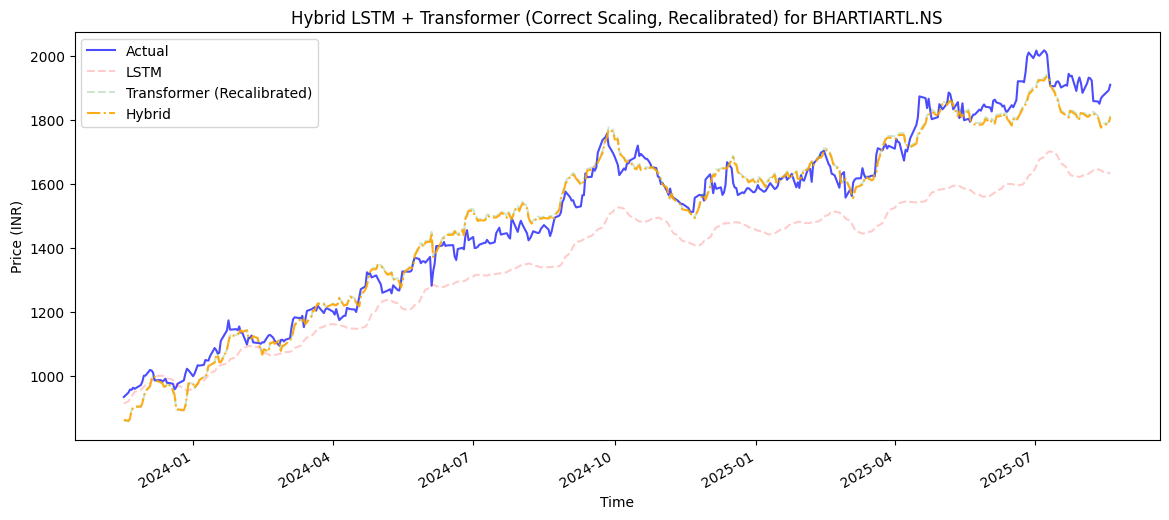

In [36]:
plt.figure(figsize=(14,6))

# Use dates from your test set index
dates = df.index[-len(actual_prices):]

plt.plot(dates, actual_prices, label="Actual", color="blue", alpha=0.7)
plt.plot(dates, lstm_preds_rescaled, label="LSTM", linestyle="--", color="red", alpha=0.2)
plt.plot(dates, trans_preds_rescaled, label="Transformer (Recalibrated)", linestyle="--", color="green", alpha=0.2)
plt.plot(dates, hybrid_preds, label="Hybrid", linestyle="-.", color="orange", alpha=0.9)

plt.xlabel("Time")
plt.ylabel("Price (INR)")
plt.title(f"Hybrid LSTM + Transformer (Correct Scaling, Recalibrated) for {symbol}", alpha=1)
plt.legend()

# Format x-axis ticks as dates
plt.xticks(rotation=45)
plt.gcf().autofmt_xdate()

plt.show()
